In [1]:
from qiskit import IBMQ, QuantumCircuit, assemble, execute, pulse, quantum_info, schedule as build_schedule, transpile 
from qiskit.ignis.verification.tomography.data import marginal_counts
from qiskit.pulse import pulse_lib, library, Play, Schedule, Waveform, DriveChannel, Gaussian, Drag
from qiskit.pulse.library.pulse import Pulse
from qiskit.scheduler import measure
from qiskit.test.mock import FakeAlmaden
from qiskit.tools.monitor import backend_monitor, backend_overview, job_monitor
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import CommutationAnalysis, CommutativeCancellation
from qiskit.visualization import plot_histogram
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import qiskit.ignis.characterization.calibrations as calib
import qiskit.ignis.characterization.coherence as coh
import qiskit.ignis.characterization.gates as char
import qiskit.ignis.mitigation.measurement as mit
import qiskit.ignis.verification.randomized_benchmarking as rb


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ncsu', group='nc-state', project='quantum-architec')
backend = provider.get_backend('ibmq_rome')
backend_config = backend.configuration()
backend_defaults = backend.defaults()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])
# print(backend_config.basis_gates)
# print(inst_sched_map)


<ipython-input-1-ee80203f56b3>:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  from qiskit.pulse import pulse_lib, library, Play, Schedule, Waveform, DriveChannel, Gaussian, Drag
/usr/local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Waveform(array([1.63902613e-06+0.j, 2.74715357e-06+0.j, 3.86778630e-06+0.j, ...,
       3.86778630e-06+0.j, 2.74715357e-06+0.j, 1.63902613e-06+0.j]), name='freq_sweep_excitation_pulse')


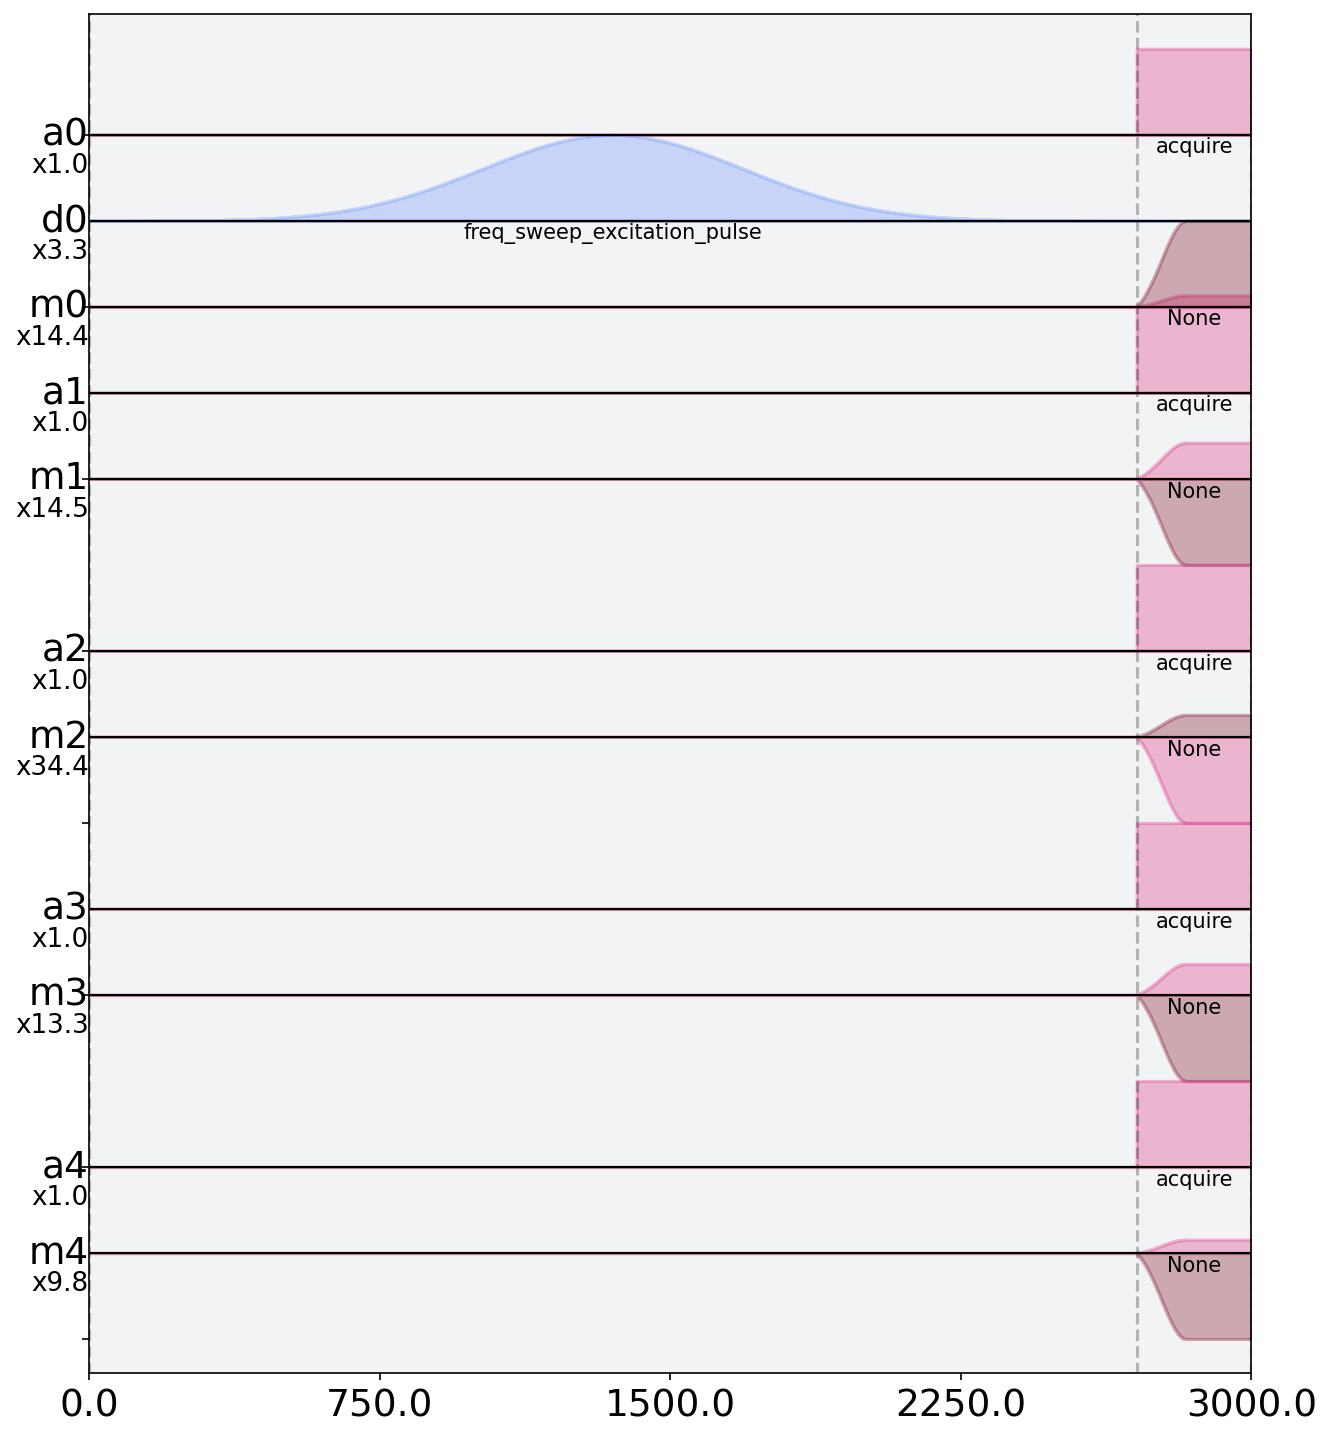

In [2]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
dt = backend_config.dt
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]
scale_factor = 1e-14
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 1 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, frequency_max / GHz, frequency_step_Hz / GHz)

def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

drive_sigma_us = 0.075                     
drive_samples_us = drive_sigma_us*8        
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
drive_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='freq_sweep_excitation_pulse')

print(drive_pulse)

meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

schedule = pulse.Schedule(name='Frequency sweep')
schedule += pulse.Play(drive_pulse, drive_chan)
schedule += measure << schedule.duration
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]
schedule.draw(plot_range=[0, 3000], table=True, label=True, channels=[])


In [3]:
# num_shots_per_frequency = 8192
# frequency_sweep_program = assemble(schedule, backend=backend, meas_level=1, meas_return='avg', shots=num_shots_per_frequency, schedule_los=schedule_frequencies)
# job = backend.run(frequency_sweep_program)
# job_monitor(job, interval=2)
job = backend.retrieve_job('5fb81d7ddd6c07001a091e74')
print(job.job_id())

5fb81d7ddd6c07001a091e74


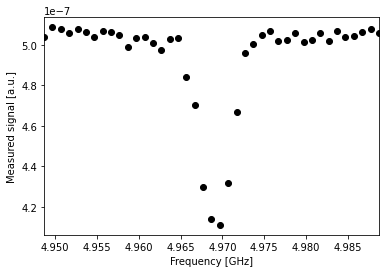

In [4]:
frequency_sweep_results = job.result()
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    res = frequency_sweep_results.get_memory(i)*scale_factor
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

4.968695946426251 GHz to 4.969181552101911 GHz.


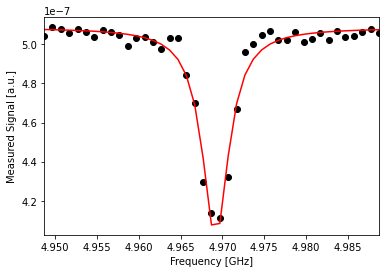

In [5]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz, np.real(sweep_values), lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C, [-5, 4.968, 0.01, 3])

A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz
print(f"{backend_defaults.qubit_freq_est[qubit]/GHz} GHz to {rough_qubit_frequency/GHz} GHz.")

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [6]:
drive_samples = 128
drive_sigma = 16
num_rabi_points = 64
drive_amps = np.linspace(0.0, 0.75, num_rabi_points)
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)
# rabi_schedules[-1].draw(plot_range=[0, 5000], table=True, label=True, channels=[])


In [7]:
# rabi_schedules_job = execute(rabi_schedules, backend, shots=8192, meas_level=1, schedule_los=[{drive_chan: rough_qubit_frequency}]* num_rabi_points)
# job_monitor(rabi_schedules_job)
rabi_schedules_job = backend.retrieve_job('5fb69eeab2f8880019c777ee')
print(rabi_schedules_job.job_id())

5fb69eeab2f8880019c777ee


Pi Amplitude = 0.3300677350337618


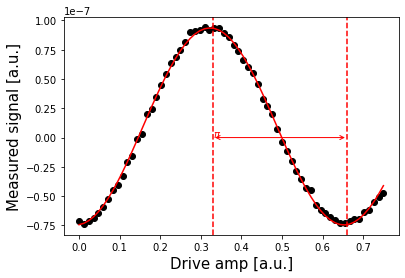

In [8]:
collect_new = True
if collect_new:
    rabi_results = rabi_schedules_job.result()
    rabi_values = []
    for i in range(len(drive_amps)):
        rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)
    np.savetxt('power_rabi.csv', rabi_values, delimiter=',')
rabi_values = np.genfromtxt('power_rabi.csv', delimiter=',', dtype=complex)
rabi_values = np.real(np.array(rabi_values) - np.mean(rabi_values))

fit_params, y_fit = fit_function(drive_amps, rabi_values, lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B), [0, 0.1, 0.5, -1])
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
drive_period = fit_params[2] # get period of rabi oscillation
pi_amp = abs(drive_period/2)
print(f"Pi Amplitude = {pi_amp}")
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2, 0), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [9]:
# drive_samples = 128 pi_amp = 0.33006773497926073 drive_sigma = 16
pi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=pi_amp, sigma=drive_sigma, name='pi_pulse')
direct_rx_schedule = Schedule(Play(pi_pulse, DriveChannel(0)))
inst_sched_map.add('x', qubits=[0], schedule=direct_rx_schedule)

In [10]:
# Direct X Gate

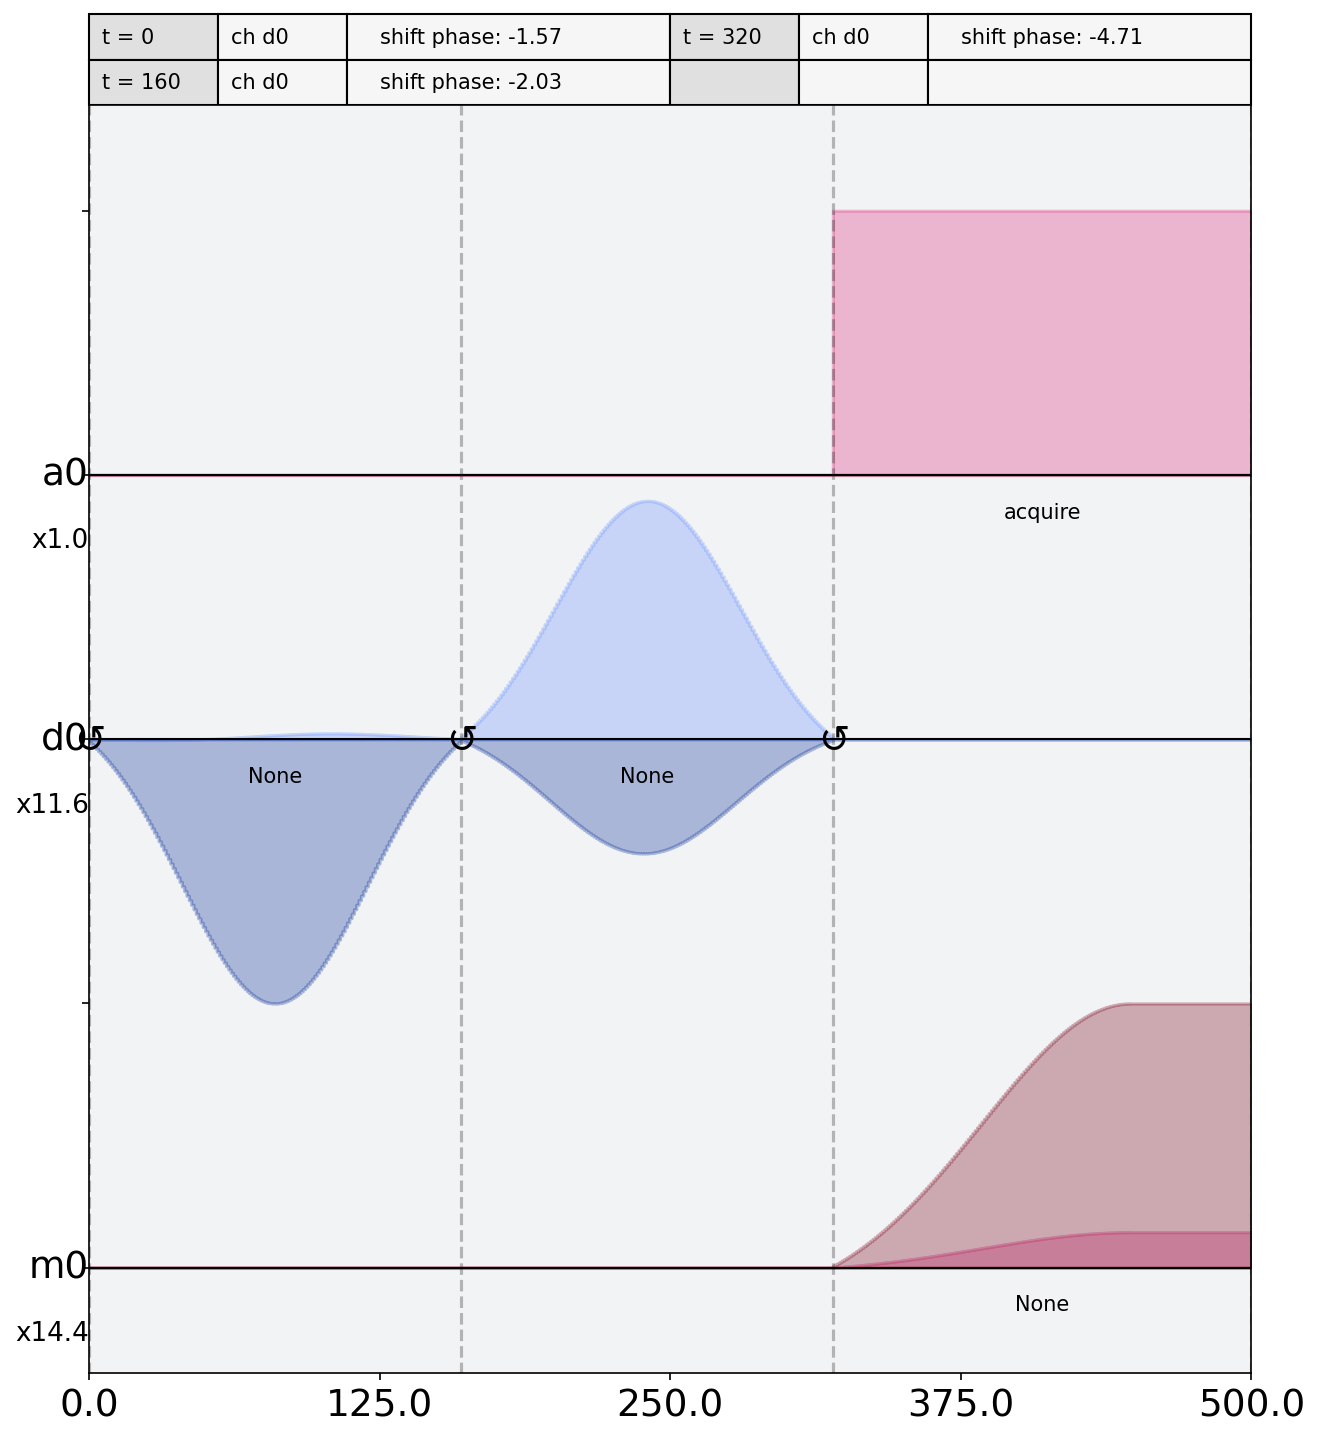

In [11]:
angles = np.linspace(0, np.pi, 18)[1:-1]
schedules = []
for angle in angles:
    schedule = inst_sched_map.get('u3', qubits=[0], P0=angle, P1=3*np.pi/2, P2=np.pi/2)
    schedule |= measure << schedule.duration
    schedules.append(schedule)
schedules[10].draw(plot_range=[0, 500], table=True, label=True, channels=[backend_config.drive(0), backend_config.measure(0), backend_config.acquire(0)])



In [12]:
# original_rx_job = execute(schedules, backend=backend, shots=8192)
# job_monitor(original_rx_job, interval=2)
original_rx_job = backend.retrieve_job('5fb8830071c3e1001b1d23e4')
print(original_rx_job.job_id())

5fb8830071c3e1001b1d23e4


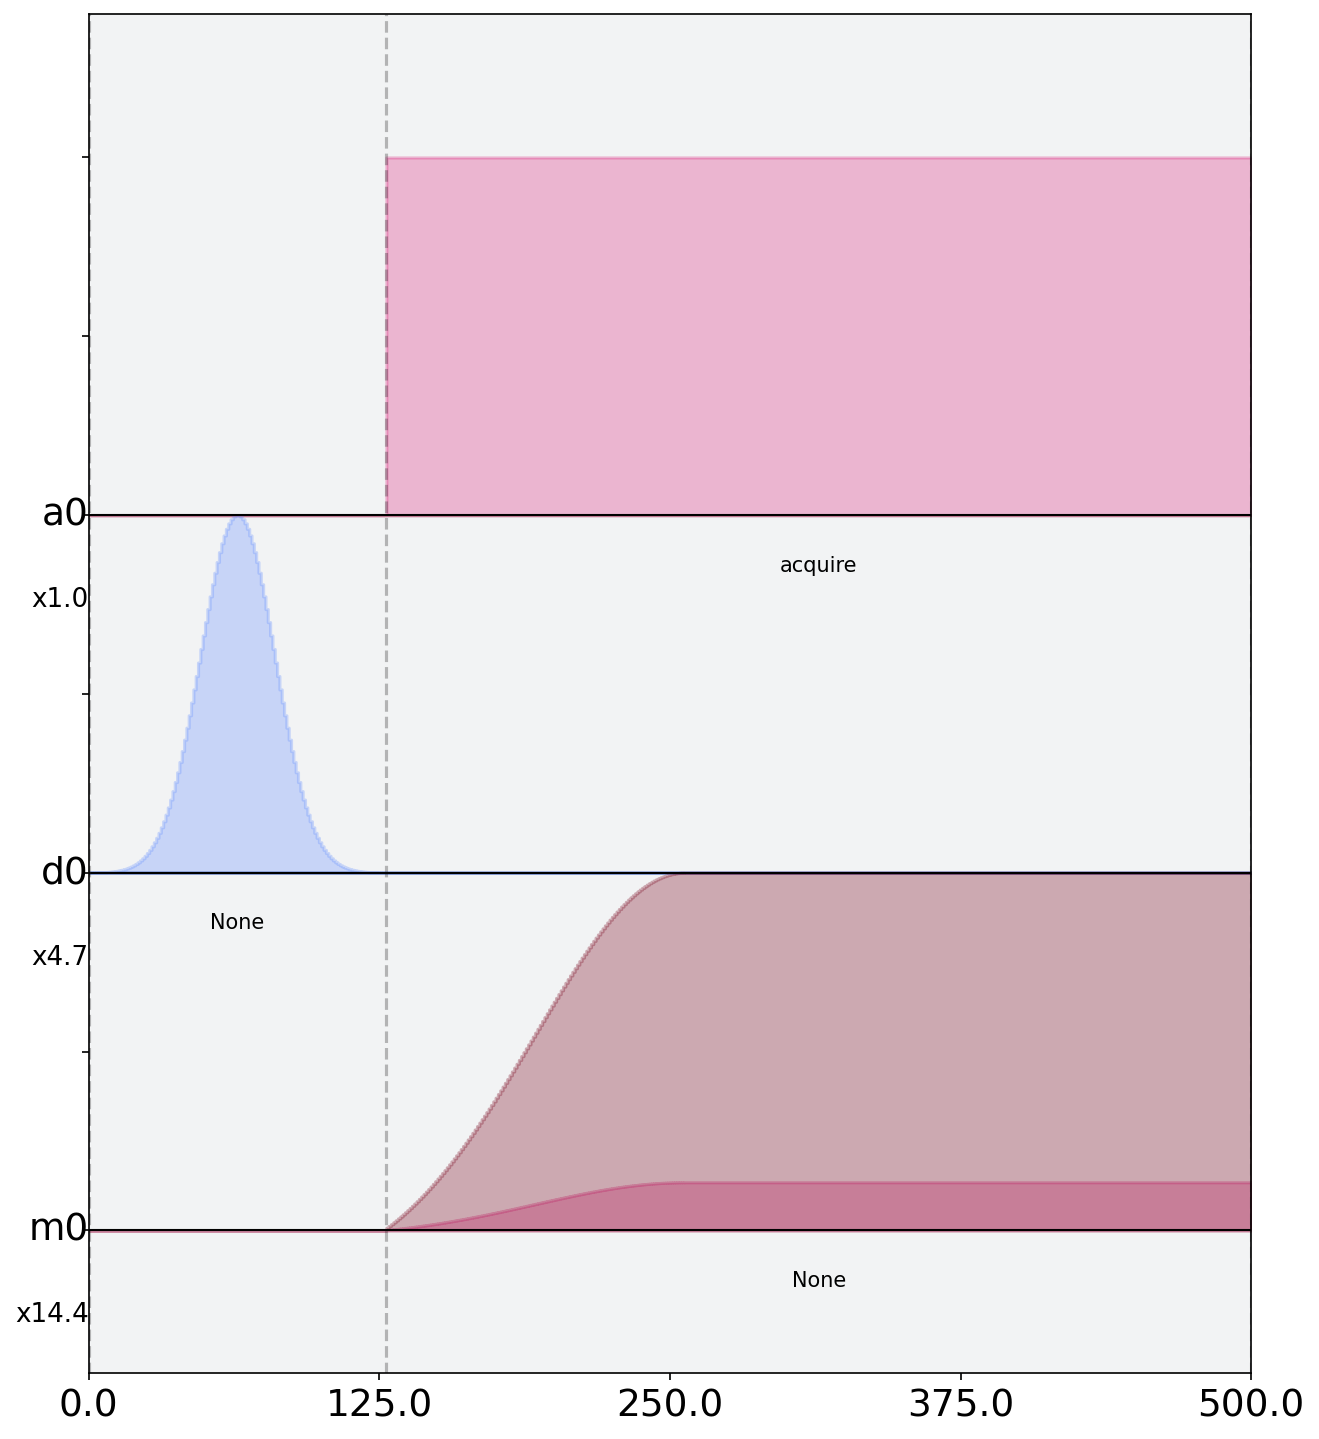

In [13]:
schedules = []
for angle in angles:
    circ = QuantumCircuit(2)
    circ.rx(angle, 0)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(decomposed_circuit, backend, inst_map=inst_sched_map)
    schedule |= measure << schedule.duration
    schedules.append(schedule)
schedules[10].draw(plot_range=[0, 500], table=True, label=True, channels=[backend_config.drive(0), backend_config.measure(0), backend_config.acquire(0)])

In [14]:
# direct_rx_job = execute(schedules, backend=backend, shots=8192)
# job_monitor(direct_rx_job, interval=2)
direct_rx_job = backend.retrieve_job('5fb883c2891237001ca4e451')
print(direct_rx_job.job_id())

5fb883c2891237001ca4e451


In [15]:
original_rx_job_result = original_rx_job.result()
direct_rx_job_result = direct_rx_job.result()

In [16]:
original_rx_job_result_fractions = []
for i in range(16):
    counts = marginal_counts(original_rx_job_result.get_counts(i), meas_qubits=[0])
    original_rx_job_result_fractions.append(counts.get('1', 0) / 8192)
    
direct_rx_job_result_fractions = []
for i in range(16):
    counts = marginal_counts(direct_rx_job_result.get_counts(i), meas_qubits=[0])
    direct_rx_job_result_fractions.append(counts.get('1', 0) / 8192)
    
expected_fractions = np.array([np.sin(angle / 2) ** 2 for angle in angles])
angles_degree = np.linspace(0, 180, 18)[1:-1]

print(np.sqrt(mean_squared_error(expected_fractions, original_rx_job_result_fractions)))
print(np.sqrt(mean_squared_error(expected_fractions, direct_rx_job_result_fractions)))


0.01675967210588296
0.0123045450295148


(0.0, 180.0, 0.0, 1.0)

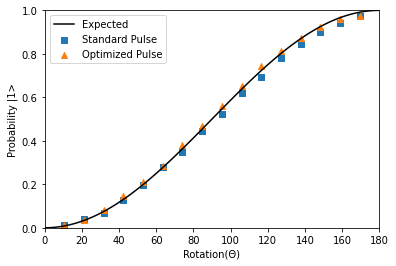

In [17]:
plt.ylabel('Probability |1>')
plt.xlabel('Rotation(Θ)')
plt.scatter(angles_degree, original_rx_job_result_fractions, marker='s', label='Standard Pulse')
plt.scatter(angles_degree, direct_rx_job_result_fractions, marker='^', label='Optimized Pulse')
plt.plot(np.linspace(0, 180, 100), [np.sin(angle * np.pi /180 / 2) ** 2 for angle in np.linspace(0, 180, 100)], label='Expected', color='black')
plt.legend()
plt.axis([0, 180, 0, 1])

(0.0, 180.0, -0.05, 0.05)

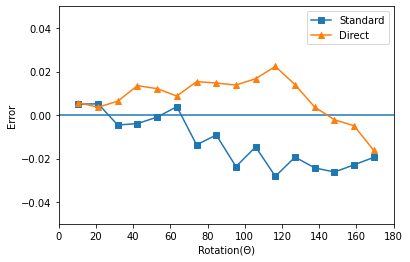

In [18]:
plt.ylabel('Error')
plt.xlabel('Rotation(Θ)')
plt.plot(angles_degree, original_rx_job_result_fractions - expected_fractions, marker='s', label='Standard')
plt.plot(angles_degree, direct_rx_job_result_fractions - expected_fractions, marker='^', label='Direct')
plt.hlines(0, 0, 180)
plt.legend()
plt.axis([0, 180, -0.05, 0.05])

In [19]:
# Cnot X Gate

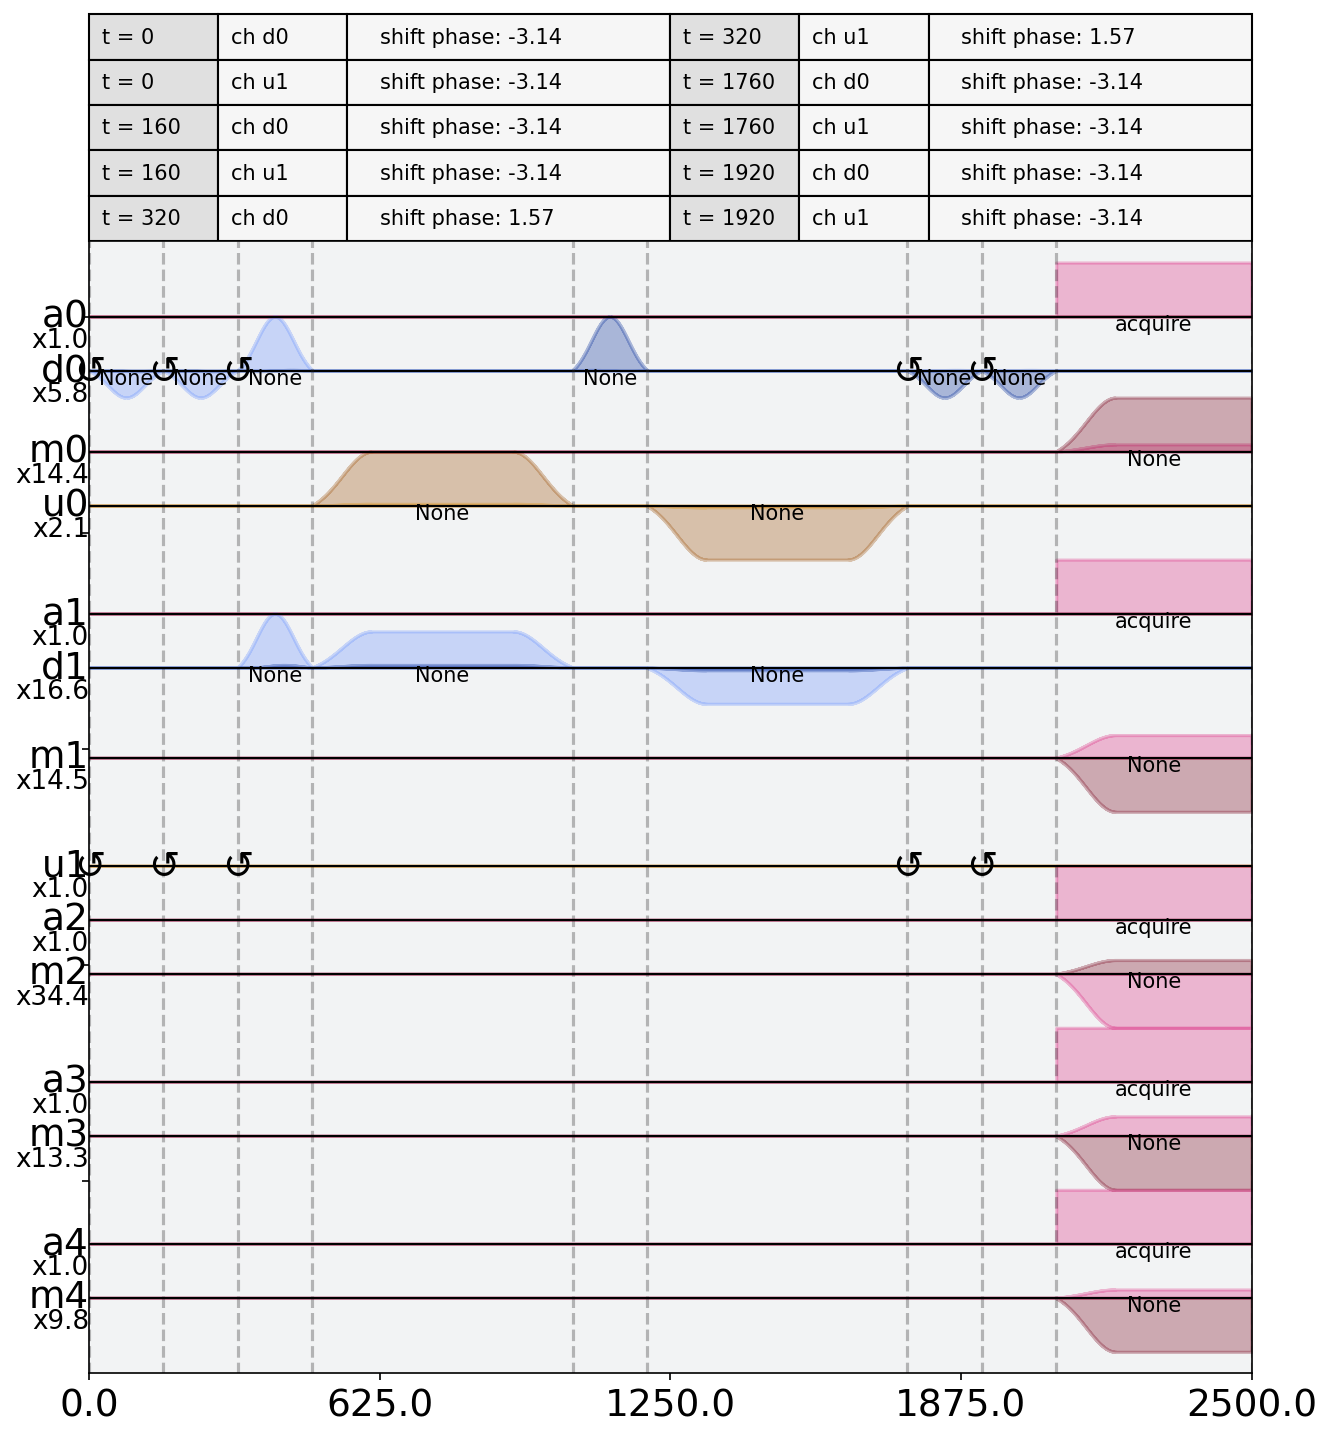

In [20]:
circ = QuantumCircuit(2, 2)

circ.x(0)
circ.cx(0, 1)
circ.x(0)
schedules = []
transpiled_circ = transpile(circ, backend)
decomposed_circuit = circ.decompose()
schedule = build_schedule(transpiled_circ, backend)
schedule |= measure << schedule.duration
schedules.append(schedule)
schedule.draw(plot_range=[0, 2500], table=True, label=True, channels=[])

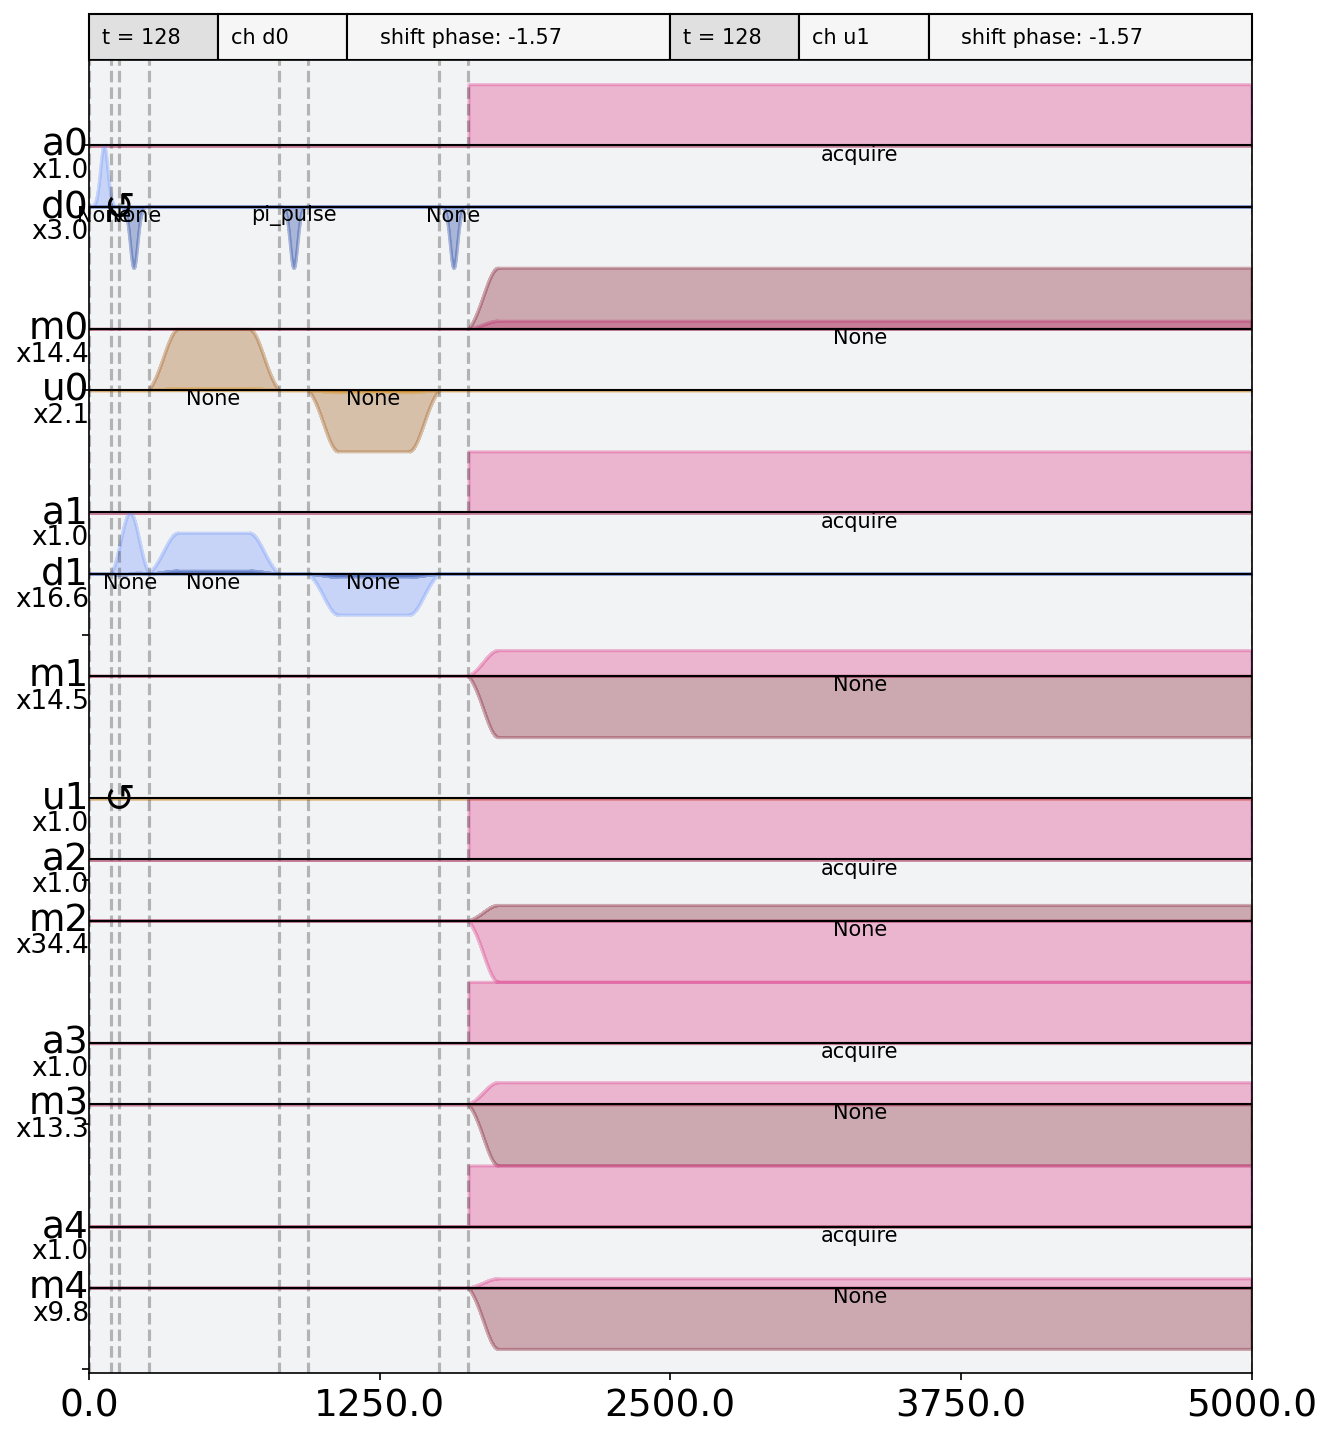

In [21]:
decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
schedule |= measure << schedule.duration
schedules.append(schedule)
schedule.draw(plot_range=[0, 5000], table=True, label=True, channels=[])

In [22]:
# cnot_job = execute(schedules, backend=backend, shots=8192)
# job_monitor(cnot_job, interval=2)
cnot_job = backend.retrieve_job('5fb9e7384a98b7001a7adc03')
print(cnot_job.job_id())

5fb9e7384a98b7001a7adc03


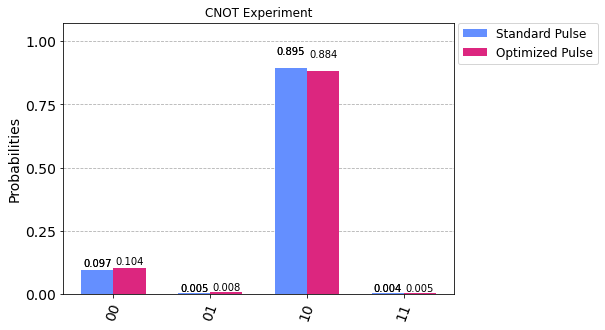

In [23]:
cnot_job_result = cnot_job.result()
counts_list = [] 
counts_list.append(marginal_counts(cnot_job_result.get_counts(0), meas_qubits=[0,1]))
counts_list.append(marginal_counts(cnot_job_result.get_counts(1), meas_qubits=[0,1]))
plot_histogram([counts_list[0], counts_list[1]], title='CNOT Experiment', legend=['Standard Pulse', 'Optimized Pulse'])


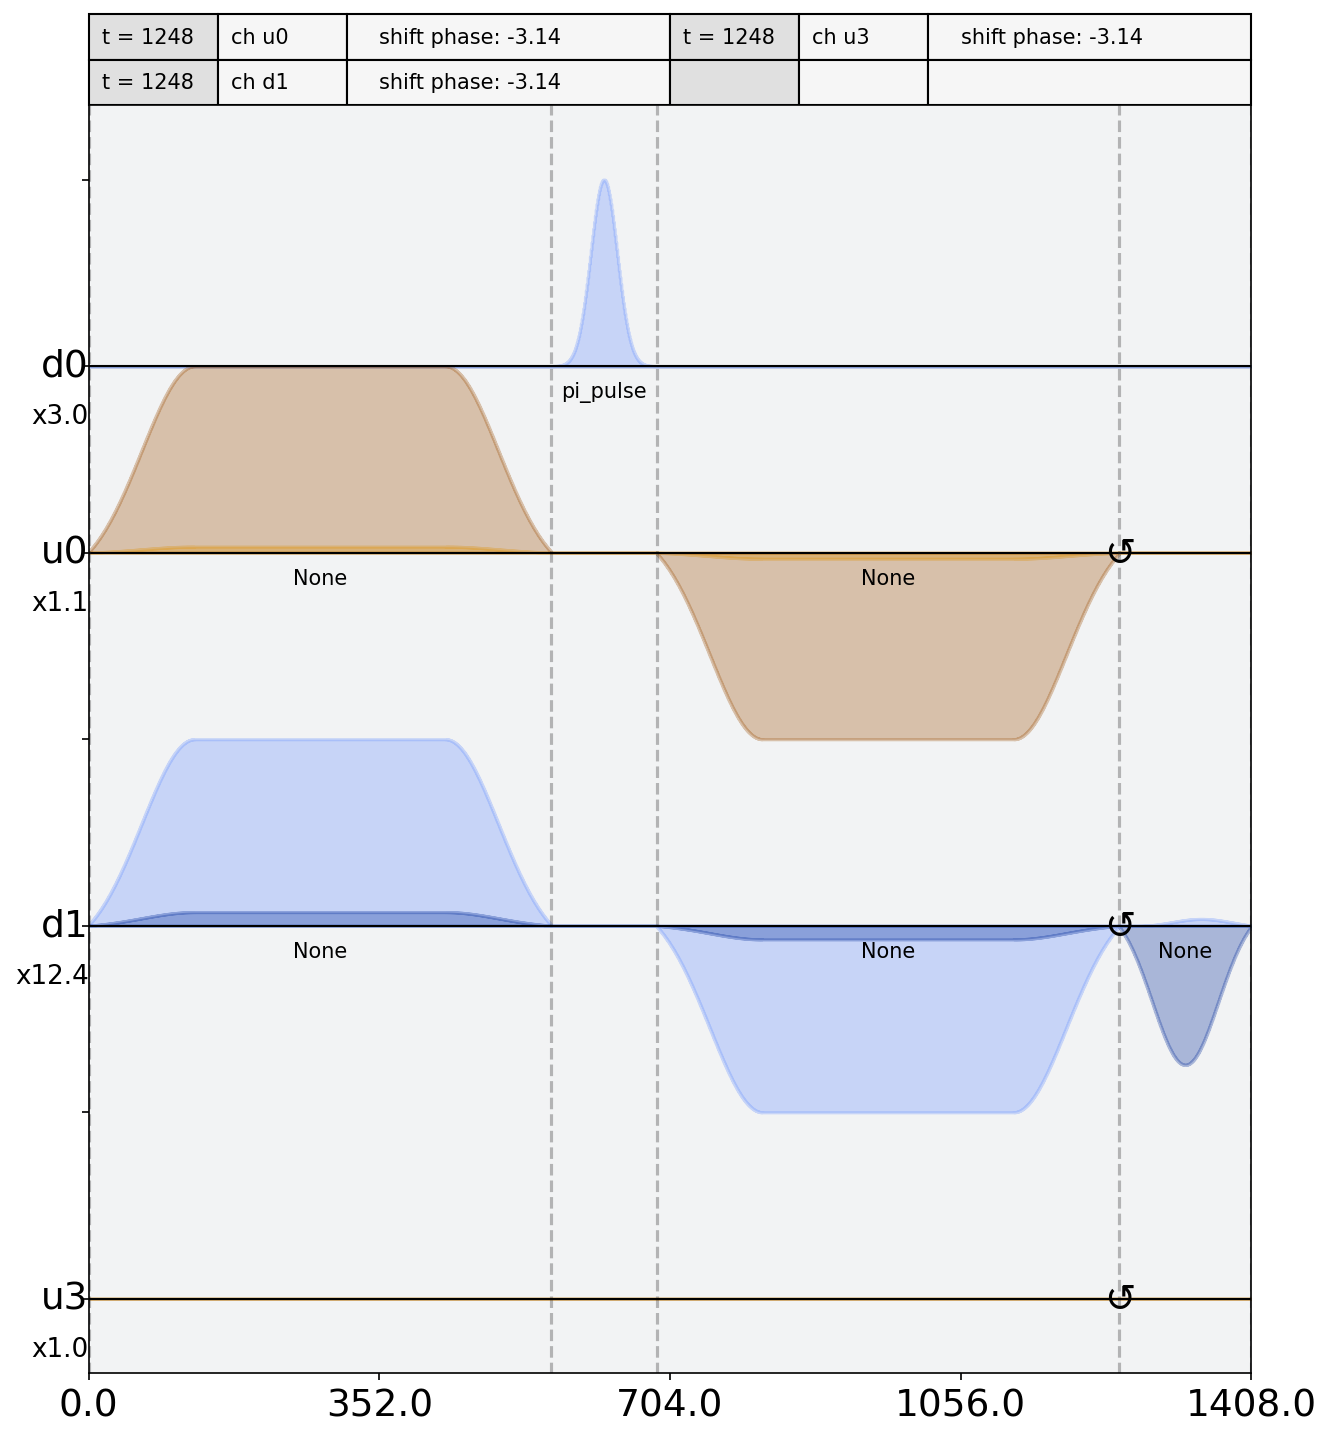

In [24]:
circ = QuantumCircuit(2)
circ.directcr(np.pi, 0, 1)
decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
schedule |= inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
# schedule |= measure << schedule.duration
schedule.draw(table=True, label=True, channels=[])

In [25]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

# Measure Y on target
y_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= inst_sched_map.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= inst_sched_map.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

# Measure Z on target
z_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.directcr(theta, 0, 1)
    decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
    transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
    schedule = build_schedule(transpiled_circuit, backend, inst_map=inst_sched_map)
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [26]:
# cr_x_job = execute(x_schedules, backend=backend, shots=8192)
# job_monitor(cr_x_job, interval=2)
cr_x_job = backend.retrieve_job('5fba031a62a80a001a41e56e')
print(cr_x_job.job_id())

# cr_y_job = execute(y_schedules, backend=backend, shots=8192)
# job_monitor(cr_y_job, interval=2)
cr_y_job = backend.retrieve_job('5fba0634162a59001a3147fa')
print(cr_y_job.job_id())

# cr_z_job = execute(z_schedules, backend=backend, shots=8192)
# job_monitor(cr_z_job, interval=2)
cr_z_job = backend.retrieve_job('5fba0920dd6c07001a093b79')
print(cr_z_job.job_id())


5fba031a62a80a001a41e56e
5fba0634162a59001a3147fa
5fba0920dd6c07001a093b79


In [27]:
cr_x_job_result = cr_x_job.result()
cr_y_job_result = cr_y_job.result()
cr_z_job_result = cr_z_job.result()

cr_x_vals_control_off = []
cr_y_vals_control_off = []
cr_z_vals_control_off = []
for i in range(41):
    cr_x_counts = marginal_counts(cr_x_job_result.get_counts(i), meas_qubits=[1])
    cr_x_vals_control_off.append((cr_x_counts.get('0', 0) / 8192 - 0.5) * 2)
    
    cr_y_counts = marginal_counts(cr_y_job_result.get_counts(i), meas_qubits=[1])
    cr_y_vals_control_off.append((cr_y_counts.get('0', 0) / 8192 - 0.5) * 2)
    
    cr_z_counts = marginal_counts(cr_z_job_result.get_counts(i), meas_qubits=[1])
    cr_z_vals_control_off.append((cr_z_counts.get('0', 0) / 8192 - 0.5) * 2)
    
    

cr_x_vals_control_on = []
cr_y_vals_control_on = []
cr_z_vals_control_on = []
for i in range(41, 82):
    cr_x_counts = marginal_counts(cr_x_job_result.get_counts(i), meas_qubits=[1])
    cr_x_vals_control_on.append((cr_x_counts.get('0', 0) / 8192 - 0.5) * 2)
    
    cr_y_counts = marginal_counts(cr_y_job_result.get_counts(i), meas_qubits=[1])
    cr_y_vals_control_on.append((cr_y_counts.get('0', 0) / 8192 - 0.5) * 2)
    
    cr_z_counts = marginal_counts(cr_z_job_result.get_counts(i), meas_qubits=[1])
    cr_z_vals_control_on.append((cr_z_counts.get('0', 0) / 8192 - 0.5) * 2)


thetas = np.linspace(0, 180, 41, endpoint=True)
dense_thetas = np.linspace(0, 180, 101, endpoint=True)

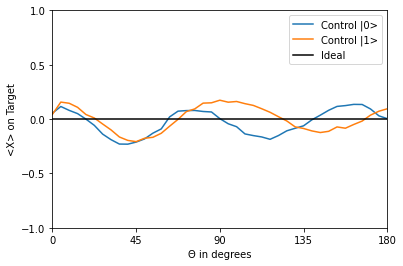

In [28]:
plt.plot(thetas, cr_x_vals_control_off, label='Control |0>')
plt.plot(thetas, cr_x_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, [0] * 101, label='Ideal', color='black')
plt.axis([0, 180, -1, 1])
plt.ylabel('<X> on Target')
plt.xlabel('Θ in degrees')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([0, 45, 90, 135, 180])
plt.legend()

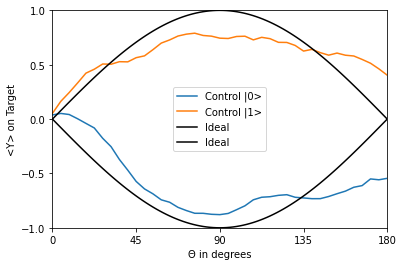

In [29]:
plt.plot(thetas, cr_y_vals_control_off, label='Control |0>')
plt.plot(thetas, cr_y_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.sin(dense_thetas*np.pi/180), label='Ideal', color='black')
plt.plot(dense_thetas, -np.sin(dense_thetas*np.pi/180), label='Ideal', color='black')
plt.axis([0, 180, -1, 1])
plt.ylabel('<Y> on Target')
plt.xlabel('Θ in degrees')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([0, 45, 90, 135, 180])
plt.legend()

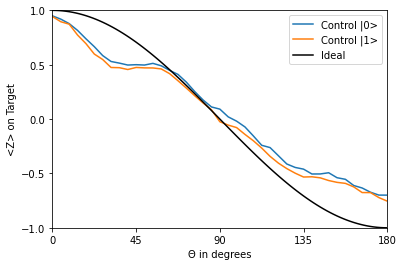

In [30]:
plt.plot(thetas, cr_z_vals_control_off, label='Control |0>')
plt.plot(thetas, cr_z_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.cos(dense_thetas*np.pi/180), label='Ideal', color='black')
plt.axis([0, 180, -1, 1])
plt.ylabel('<Z> on Target')
plt.xlabel('Θ in degrees')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([0, 45, 90, 135, 180])
plt.legend()

In [31]:
schedules = []
HH = inst_sched_map.get('u2', qubits=[0], P0=0, P1=np.pi) | inst_sched_map.get('u2', qubits=[1], P0=0, P1=np.pi)
CNOT_RZ_CNOT = inst_sched_map.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= inst_sched_map.get('u1', qubits=[1], P0=np.pi / 2) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= inst_sched_map.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration
RXRX = inst_sched_map.get('u3', qubits=[0], P0=3 * np.pi / 4, P1=3*np.pi/2, P2=np.pi/2) | inst_sched_map.get('u3', qubits=[1], P0=3 * np.pi / 4, P1=3*np.pi/2, P2=np.pi/2)
schedule = HH
schedule |= CNOT_RZ_CNOT << schedule.duration
schedule |= RXRX << schedule.duration
schedule |= measure << schedule.duration
schedules.append(schedule)


In [32]:
circ = QuantumCircuit(2)
circ.h(0)
circ.h(1)
circ.directzzgate(np.pi / 2, 0, 1)
circ.rx(3 * np.pi / 4, 0)
circ.rx(3 * np.pi / 4, 1)

decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
schedule = build_schedule(decomposed_circuit, backend=backend, inst_map=inst_sched_map)
schedule |= measure << schedule.duration
schedules.append(schedule)

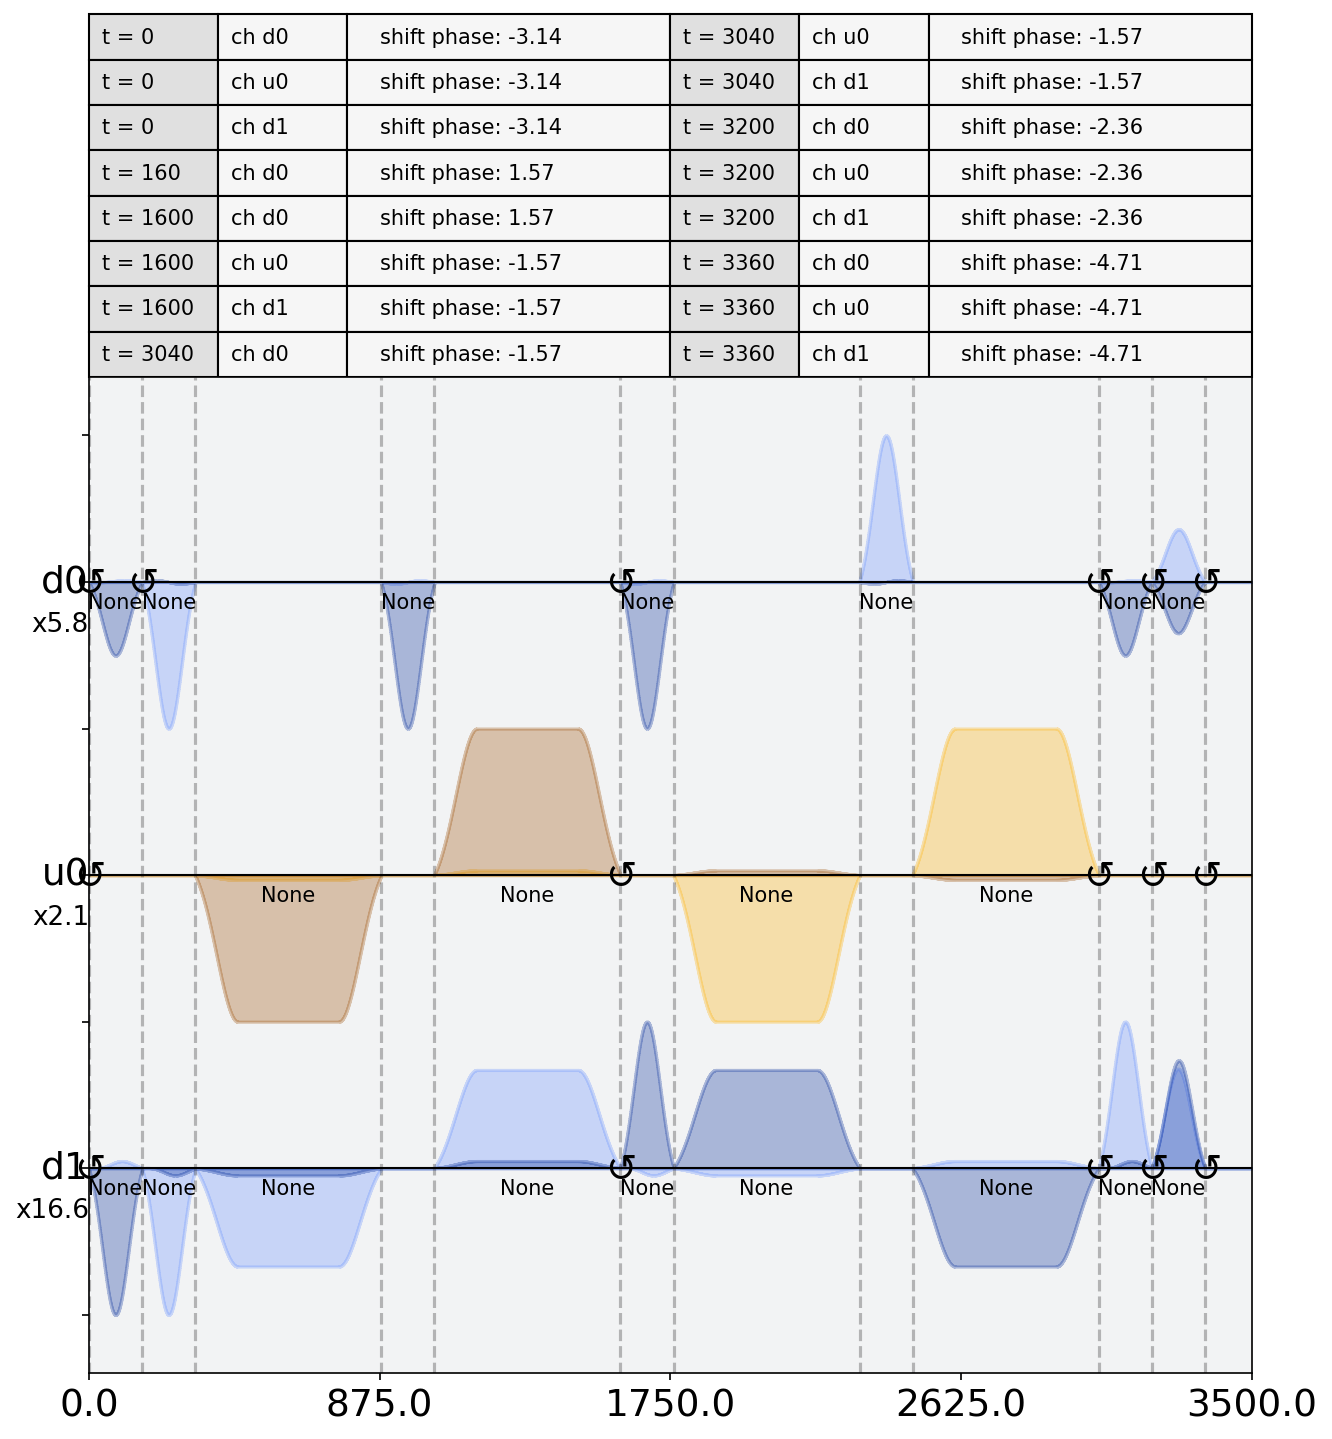

In [33]:
schedules[0].draw(plot_range=[0, 3500], table=True, label=True, 
                  channels=[backend_config.drive(0), backend_config.drive(1), backend_config.control(qubits=[0,1])[0]])

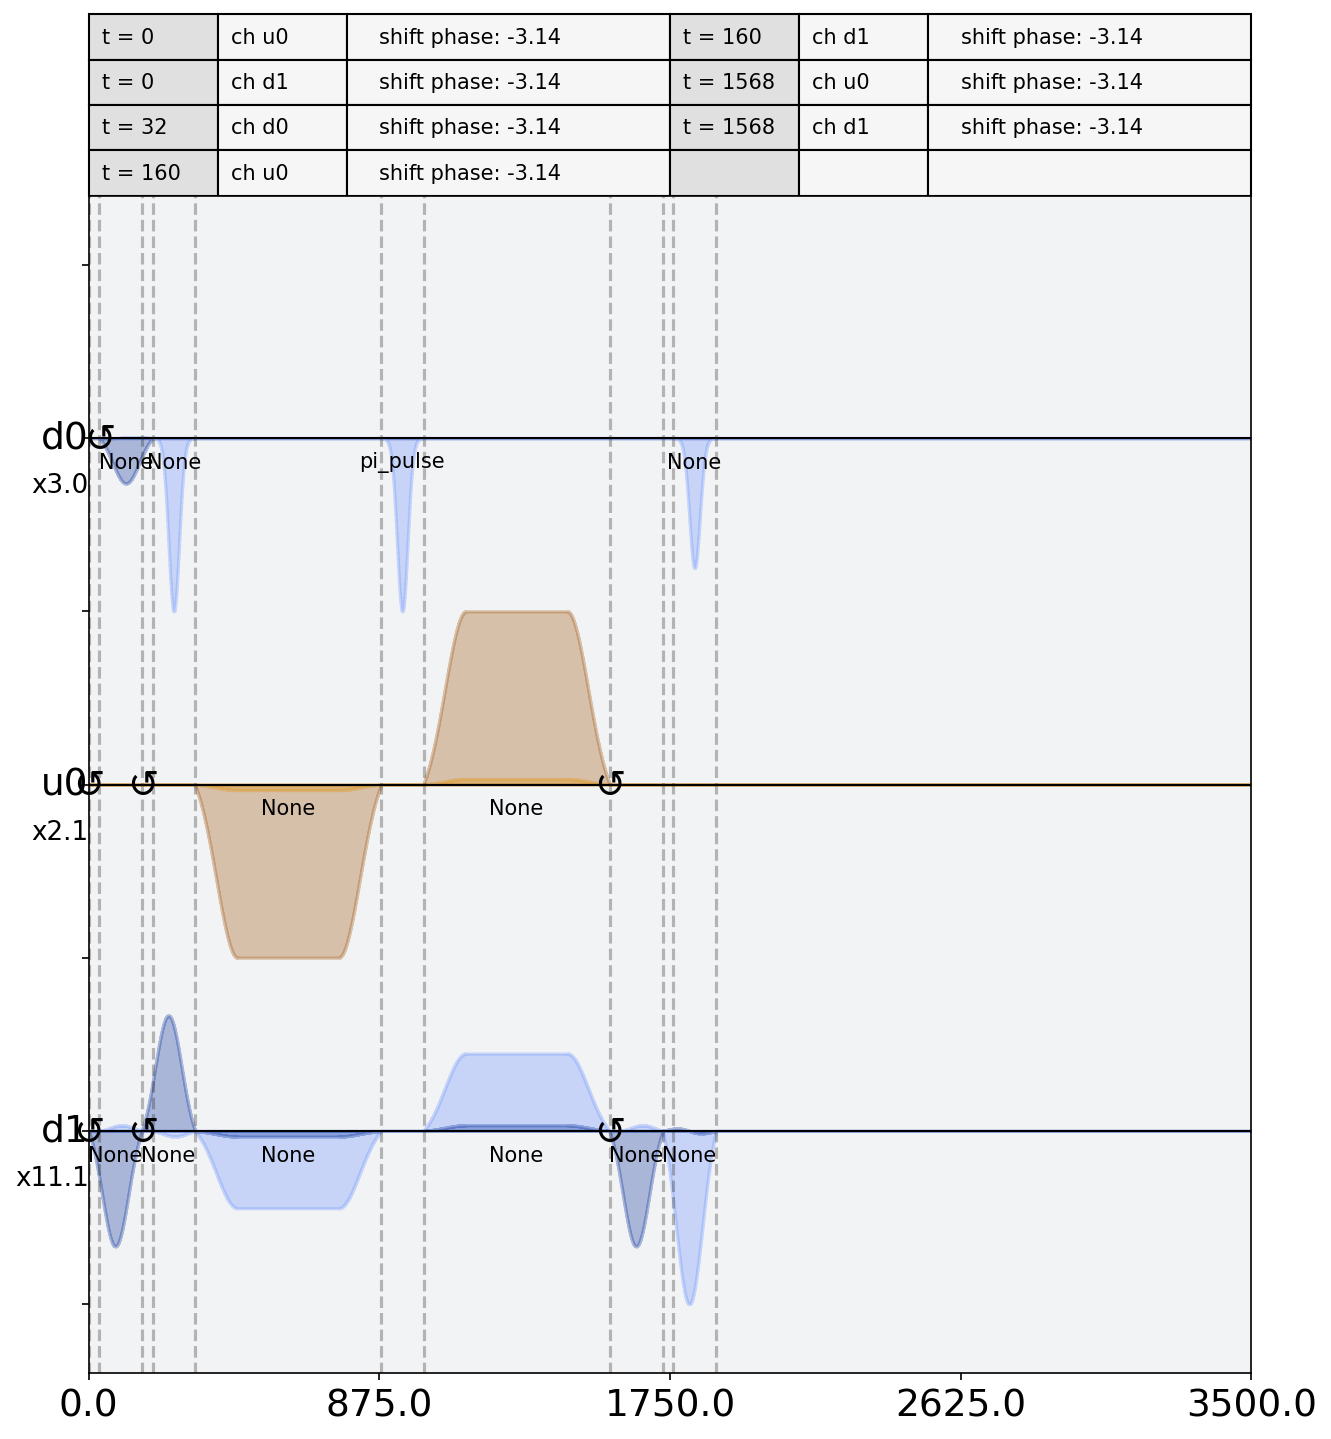

In [34]:
schedules[1].draw(plot_range=[0, 3500], table=True, label=True, 
                  channels=[backend_config.drive(0), backend_config.drive(1), backend_config.control(qubits=[0,1])[0]])

In [35]:
# qaoa_2_bit_job = execute(schedules, backend=backend, shots=8192)
# job_monitor(qaoa_2_bit_job, interval=2)
qaoa_2_bit_job = backend.retrieve_job('5fba26c4891237001ca4f6ff') # 5fba31d371c3e1001b1d370d
print(qaoa_2_bit_job.job_id())

meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = build_schedule(meas_qcs_transpiled, backend=backend, inst_map=inst_sched_map)

# mit_job = execute(meas_schedules, backend)
# job_monitor(mit_job, interval=2)
mit_job = backend.retrieve_job('5fba2965447a61001a38123f')
print(mit_job.job_id())


5fba26c4891237001ca4f6ff
5fba2965447a61001a38123f


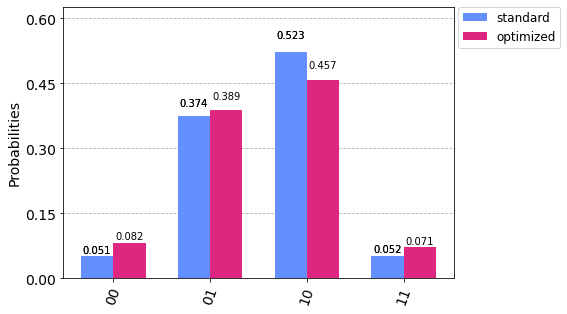

In [47]:
qaoa_2_bit_job_result = qaoa_2_bit_job.result()

ideal_counts = {'01': 4096, '10': 4096}

mit_job_result = mit_job.result()
readout_fitter = mit.CompleteMeasFitter(mit_job_result, meas_labels)

standard_counts =  marginal_counts(qaoa_2_bit_job_result.get_counts(0), [0,1])
# standard_counts = readout_fitter.filter.apply(standard_counts)
optimized_counts = marginal_counts(qaoa_2_bit_job_result.get_counts(1), [0,1])
# optimized_counts = readout_fitter.filter.apply(optimized_counts)
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [37]:
def kl_divergence(ideal_counts, actual_counts):
    ideal_total = sum(ideal_counts.values())
    actual_total = sum(actual_counts.values())
    kl_div = 0
    for k, v in ideal_counts.items():
        p = v / ideal_total
        q = actual_counts.get(k, 0) / actual_total
        if q != 0:
            kl_div += p * np.log(p / q)
    return kl_div


def cross_entropy(ideal_counts, actual_counts):
    ideal_total = sum(ideal_counts.values())
    actual_total = sum(actual_counts.values())
    cross_entropy = 0
    for k, v in ideal_counts.items():
        p = v / ideal_total
        q = actual_counts.get(k, 0) / actual_total
        if q != 0:
            cross_entropy += -p * np.log(q)
    return cross_entropy

print(f"kl_divergence: {kl_divergence(ideal_counts, standard_counts)}")
print(f"kl_divergence: {kl_divergence(ideal_counts, optimized_counts)}")
print(f"cross_entropy: {cross_entropy(ideal_counts, standard_counts)}")
print(f"cross_entropy: {cross_entropy(ideal_counts, optimized_counts)}")
print(f"fidelity: {quantum_info.hellinger_fidelity(ideal_counts, standard_counts)}")
print(f"fidelity: {quantum_info.hellinger_fidelity(ideal_counts, optimized_counts)}")

kl_divergence: 0.12277700795937374
kl_divergence: 0.16952266943305494
cross_entropy: 0.8159241885193191
cross_entropy: 0.8626698499930002
fidelity: 0.7628198657039137
fidelity: 0.716231123383716


In [38]:
schedules = []
schedule = (inst_sched_map.get('u2', qubits=[0], P0=0, P1=1) | inst_sched_map.get('u2', qubits=[1], P0=-np.pi/2, P1=np.pi/2))
schedule |= inst_sched_map.get('cx', qubits=[0, 1]) << schedule.duration
schedule |= inst_sched_map.get('u1', qubits=[1], P0=np.pi/3) << schedule.duration
schedule |= inst_sched_map.get('cx', qubits=[0, 1]) << schedule.duration
schedule |= (inst_sched_map.get('u2', qubits=[0], P0=np.pi, P1=-np.pi) | inst_sched_map.get('u2', qubits=[1], P0=-np.pi/2, P1=np.pi/2)) << schedule.duration
schedule |= measure << schedule.duration
schedules.append(schedule)

circ = QuantumCircuit(2)
circ.ry(np.pi / 2, 0)
circ.rx(np.pi / 2, 1)
circ.directzzgate(np.pi/3, 0, 1)
circ.ry(-np.pi / 2, 0)
circ.rx(np.pi / 2, 1)

decomposed_circuit = circ.decompose(backend=backend, optimize_using_open_pulse=True)
transpiled_circuit = transpile(decomposed_circuit, backend, optimization_level=1)
schedule = build_schedule(transpiled_circuit, backend=backend, inst_map=inst_sched_map)
schedule |= measure << schedule.duration
schedules.append(schedule)

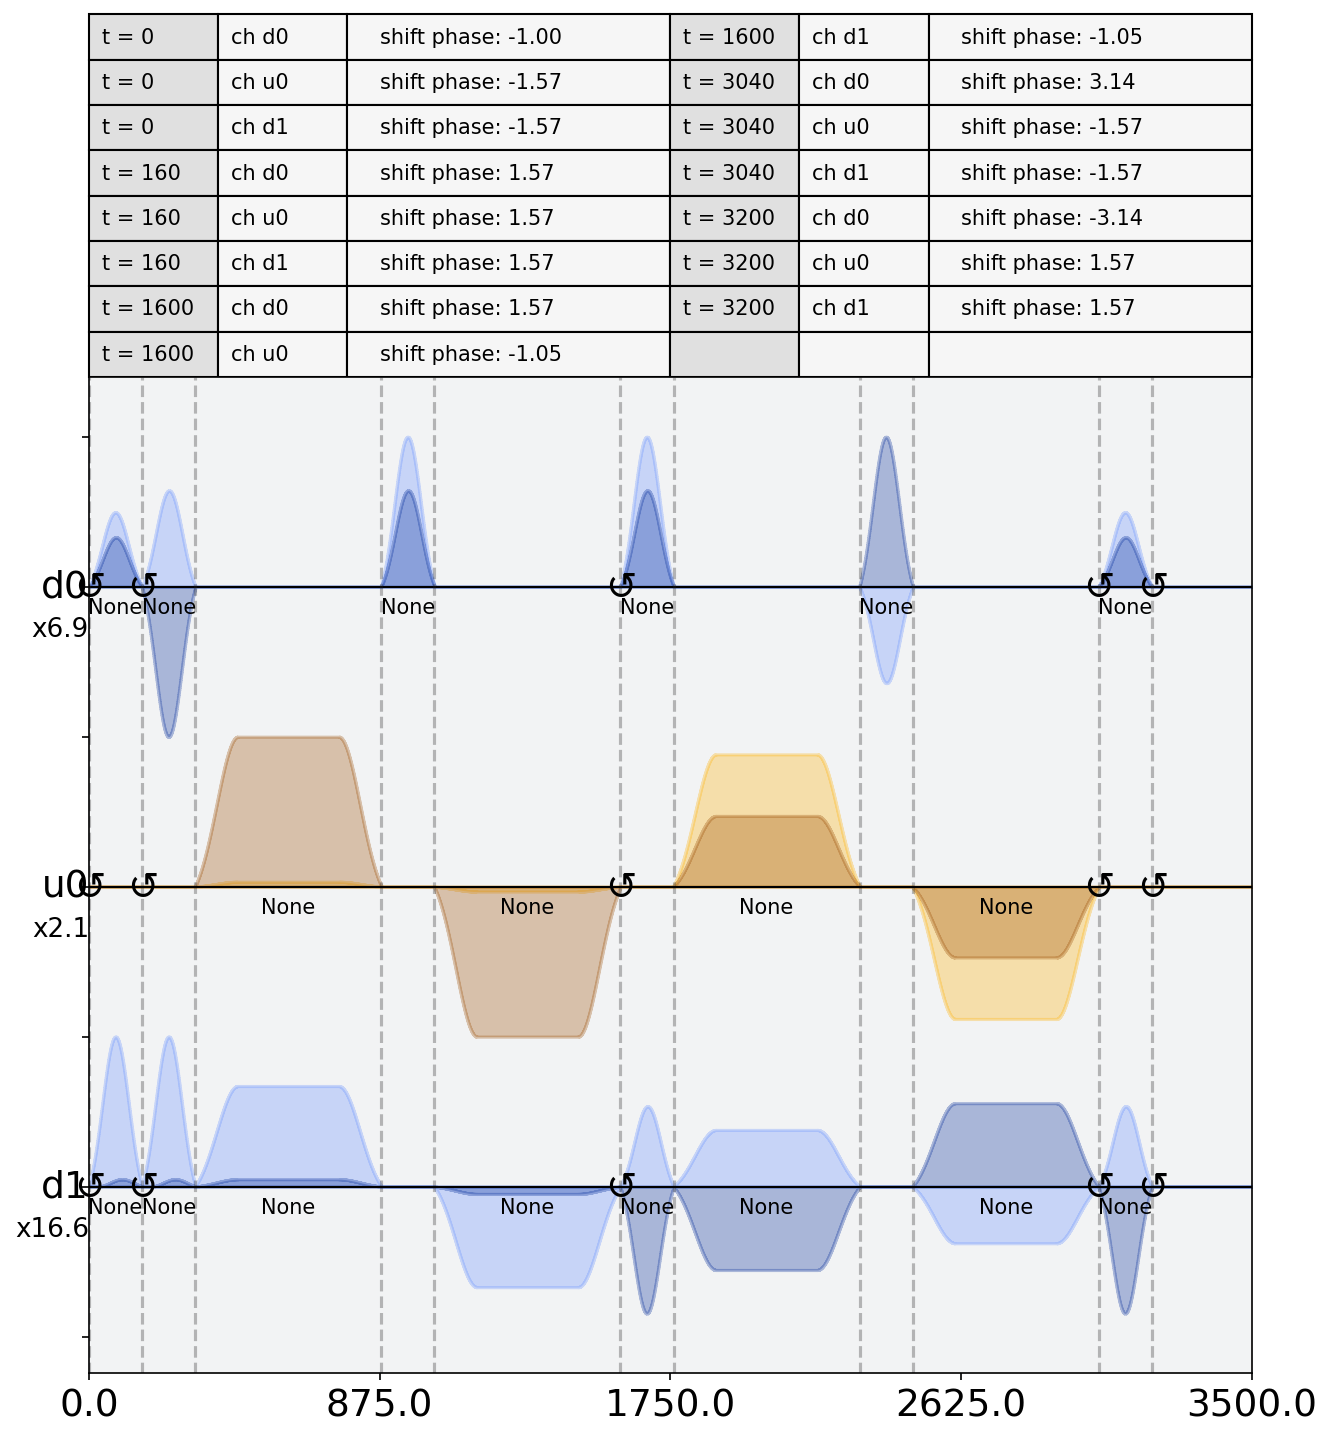

In [39]:
schedules[0].draw(plot_range=[0, 3500], table=True, label=True, 
                  channels=[backend_config.drive(0), backend_config.drive(1), backend_config.control(qubits=[0,1])[0]])

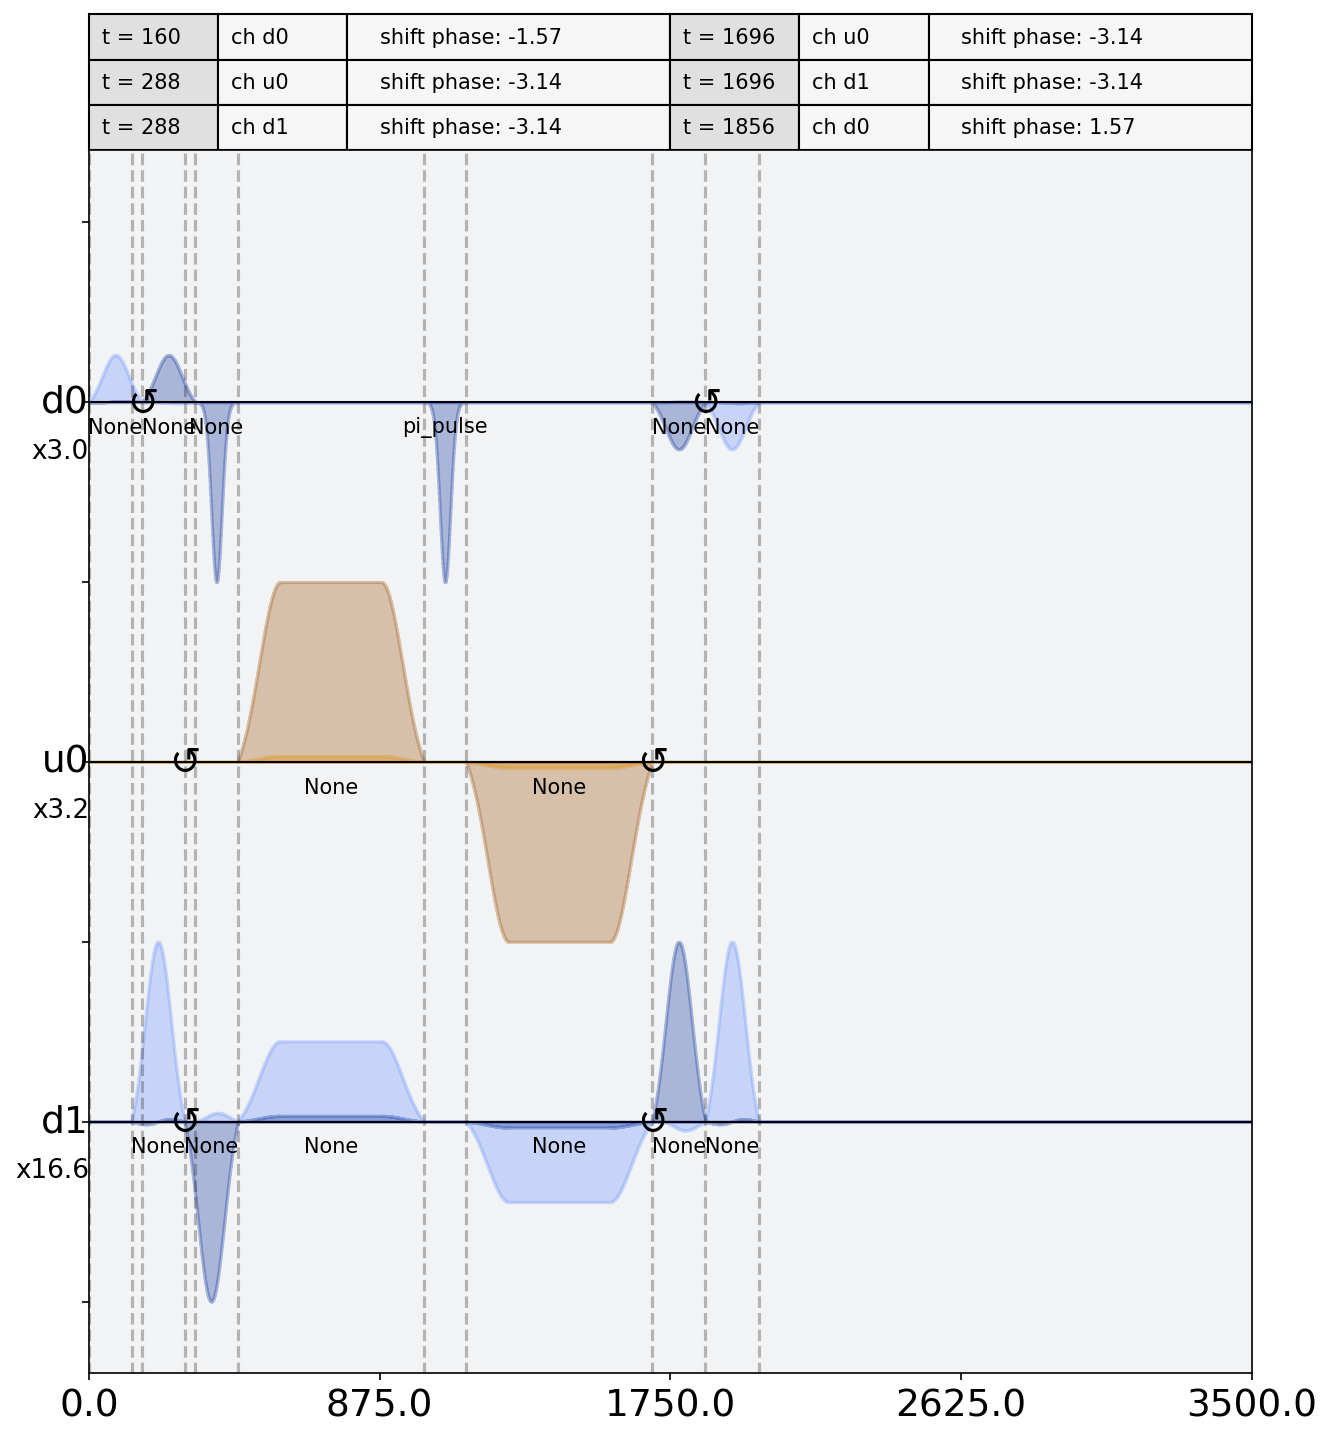

In [40]:
schedules[1].draw(plot_range=[0, 3500], table=True, label=True, 
                  channels=[backend_config.drive(0), backend_config.drive(1), backend_config.control(qubits=[0,1])[0]])

In [42]:
# h2_vqe_2_bit_job = execute(schedules, backend=backend, shots=8192)
# job_monitor(h2_vqe_2_bit_job, interval=2)
h2_vqe_2_bit_job = backend.retrieve_job('5fba48ef62a80a001a41ea31')
print(h2_vqe_2_bit_job.job_id())

mit_job = backend.retrieve_job('5fba2965447a61001a38123f')
print(mit_job.job_id())


5fba48ef62a80a001a41ea31
5fba2965447a61001a38123f


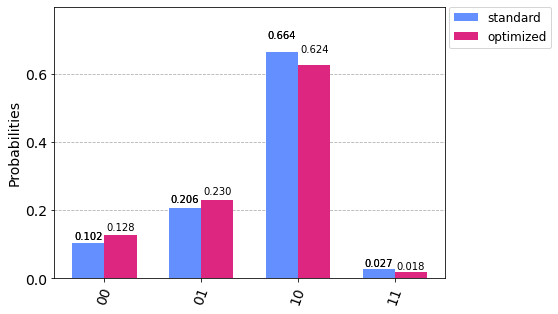

In [46]:
h2_ideal_counts = {'01': 0.25, '10': 0.75}

h2_vqe_2_bit_job_result = h2_vqe_2_bit_job.result()
mit_job_result = mit_job.result()
readout_fitter = mit.CompleteMeasFitter(mit_job_result, meas_labels)

h2_standard_counts = marginal_counts(h2_vqe_2_bit_job_result.get_counts(0), [0,1])
# h2_standard_counts = readout_fitter.filter.apply(h2_standard_counts)
h2_optimized_counts = marginal_counts(h2_vqe_2_bit_job_result.get_counts(1), [0,1])
# h2_optimized_counts = readout_fitter.filter.apply(h2_optimized_counts)
plot_histogram([h2_standard_counts, h2_optimized_counts], legend=['standard', 'optimized'])

In [ ]:
print(f"kl_divergence: {kl_divergence(h2_ideal_counts, h2_standard_counts)}")
print(f"kl_divergence: {kl_divergence(h2_ideal_counts, h2_optimized_counts)}")
print(f"cross_entropy: {cross_entropy(h2_ideal_counts, h2_standard_counts)}")
print(f"cross_entropy: {cross_entropy(h2_ideal_counts, h2_optimized_counts)}")
print(f"fidelity: {quantum_info.hellinger_fidelity(h2_ideal_counts, h2_standard_counts)}")
print(f"fidelity: {quantum_info.hellinger_fidelity(h2_ideal_counts, h2_optimized_counts)}")